<a href="https://colab.research.google.com/github/mayarmostaf/Hand-Gesture-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#### Load Data

In [7]:
data = pd.read_csv('preprocessed_data_variations/df3_transformed.csv')# with Tip Finger Scaling

In [8]:
# Load target_encoder
loaded_target_encoder = joblib.load('preprocessing_models/target_encoder.pkl')
data["target"]=loaded_target_encoder.transform(data["label"])

##### Splitting

In [17]:
X=data.drop(columns=["label","target"])
Y=data["target"]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["label","target"]), data["target"], test_size=0.2, random_state=42, stratify=data["target"])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(20540, 42)
(20540,)
(5135, 42)
(5135,)
target
15    0.064362
8     0.064216
3     0.063632
6     0.062025
13    0.061003
0     0.058666
10    0.058325
12    0.057741
11    0.056767
14    0.056719
9     0.056134
4     0.055940
17    0.053408
16    0.052288
1     0.050438
7     0.049172
5     0.042356
2     0.036806
Name: proportion, dtype: float64
target
15    0.064460
8     0.064265
3     0.063681
6     0.061928
13    0.061149
0     0.058617
10    0.058228
12    0.057644
11    0.056865
14    0.056670
9     0.056086
4     0.055891
17    0.053359
16    0.052386
1     0.050438
7     0.049270
5     0.042259
2     0.036806
Name: proportion, dtype: float64


### Model Selection

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

# Define the hyperparameters grid for Random Search
param_dist = {
    'n_neighbors': np.arange(1, 21),  # Number of neighbors to test (1 to 20)
    'weights': ['uniform', 'distance'],  # Different weighting strategies
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Initialize the KNN classifier
clf = KNeighborsClassifier()

# Perform RandomizedSearchCV using cross-validation
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X, Y)  # Fit on the full data

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best hyperparameters found: {best_params}")

# Cross-validation score (mean score across folds)
cv_score = random_search.best_score_
print(f'Cross-validation score after Random Search: {cv_score * 100:.2f}%')

# Get the best model
best_model = random_search.best_estimator_

# Save the best model to disk
joblib.dump(best_model, 'best_knn_model.pkl')


Best hyperparameters found: {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
Cross-validation score after Random Search: 97.52%


['best_knn_model.pkl']

In [31]:
best_model = random_search.best_estimator_
joblib.dump(best_model, 'model_variations/best_knn_model.pkl')

['model_variations/best_knn_model.pkl']

#### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameters grid for Random Search
param_dist = {
    'max_depth': [3, 6, 9, 12],  # Different maximum depths of trees
    'learning_rate': [0.01, 0.1, 0.3, 0.5],  # Different learning rates (eta)
    'n_estimators': [50, 100, 200],  # Number of trees
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples to use for fitting
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features to use per tree
}

# Initialize the XGBClassifier
model = XGBClassifier()

# Perform RandomizedSearchCV using cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X, Y)  # Fit on the full data

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print(f"Best hyperparameters found: {best_params}")

# Cross-validation score (mean score across folds)
cv_score = random_search.best_score_

# Print the cross-validation score
print(f'Cross-validation score after Random Search: {cv_score * 100:.2f}%')


Best hyperparameters found: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Cross-validation score after Random Search: 98.24%


In [25]:
best_model = random_search.best_estimator_
joblib.dump(best_model, 'model_variations/best_xgb_model.pkl')

['model_variations/best_xgb_model.pkl']

#### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np


# Define the hyperparameters grid for Random Search
param_dist = {
    'n_estimators': [50, 100, 200],  # Number of estimators (trees)
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0],  # Learning rate for AdaBoost
    'base_estimator__max_depth': [1, 3, 5, 7],  # Maximum depth for DecisionTree
    'base_estimator__min_samples_split': [2, 5, 10]  # Min samples to split for DecisionTree
}

# Initialize the AdaBoostClassifier with a DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)  # Simple decision tree
adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator)

# Perform RandomizedSearchCV using cross-validation
random_search = RandomizedSearchCV(adaboost_classifier, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X, Y)  # Fit on the full data

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print(f"Best hyperparameters found: {best_params}")

# Cross-validation score (mean score across folds)
cv_score = random_search.best_score_

# Print the cross-validation score
print(f'Cross-validation score after Random Search: {cv_score * 100:.2f}%')


d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best hyperparameters found: {'n_estimators': 100, 'learning_rate': 0.5, 'base_estimator__min_samples_split': 2, 'base_estimator__max_depth': 7}
Cross-validation score after Random Search: 97.52%
Accuracy on test data after Random Search: 99.44%


In [28]:
best_model = random_search.best_estimator_
joblib.dump(best_model, 'model_variations/best_ada_model.pkl')

['model_variations/best_ada_model.pkl']

#### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Define the hyperparameters grid for Random Search
param_dist = {
    'n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for splitting
    'max_depth': [None, 10, 20, 30, 40, 50],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Min samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV using cross-validation
random_search = RandomizedSearchCV(random_forest_classifier, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X, Y)  # Fit on the full data

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print(f"Best hyperparameters found: {best_params}")

# Cross-validation score (mean score across folds)
cv_score = random_search.best_score_

# Print the cross-validation score
print(f'Cross-validation score after Random Search: {cv_score * 100:.2f}%')


d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\base.py", line 

Best hyperparameters found: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
Cross-validation score after Random Search: 97.88%
Random Forest Accuracy on test data after Random Search: 99.98%


In [33]:
best_model = random_search.best_estimator_
joblib.dump(best_model, 'model_variations/best_rf_model.pkl')

['model_variations/best_rf_model.pkl']

#### SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

param_dist = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [3, 4, 5],  # Degree of the polynomial kernel function
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'coef0': [0, 0.1, 0.5],  # Independent term in kernel function
    'shrinking': [True, False],  # Whether to use the shrinking heuristic
    'tol': [1e-3, 1e-4],  # Tolerance for stopping criteria
    'max_iter': [1000, 2000, -1]  # Maximum number of iterations
}

svc_classifier = SVC(random_state=42)
random_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X, Y)  # Fit on the full data

# best hyperparameters
best_params = random_search.best_params_
print(f"Best hyperparameters found: {best_params}")

# Cross-validation score (mean score across folds)
cv_score = random_search.best_score_

# the cross-validation score
print(f'Cross-validation score after Random Search: {cv_score * 100:.2f}%')

Best hyperparameters found: {'tol': 0.001, 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'coef0': 0.5, 'C': 1}
Cross-validation score after Random Search: 98.73%


d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [35]:
best_model = random_search.best_estimator_
joblib.dump(best_model, 'model_variations/best_svc_model.pkl')

['model_variations/best_svc_model.pkl']

##### Conclusion:
 SVC is The Best Model

In [22]:
# Best parameters found by Grid Search
best_grid_params = grid_search.best_params_
print(f"Best hyperparameters found from Grid Search: {best_grid_params}")

# Cross-validation score (mean score across folds)
grid_cv_score = grid_search.best_score_
print(f'Cross-validation score after Grid Search: {grid_cv_score * 100:.2f}%')

# Best model accuracy on full dataset
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Model accuracy on full dataset: {accuracy * 100:.2f}%")


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

### Model Evaluation

In [12]:
# Load the saved models
loaded_model = joblib.load('model_variations/best_svc_model.pkl')
loaded_target_encoder = joblib.load('preprocessing_models/target_encoder.pkl')

d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\m\supervised ml\Hand-Gesture-Classification\.venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\m\supervi

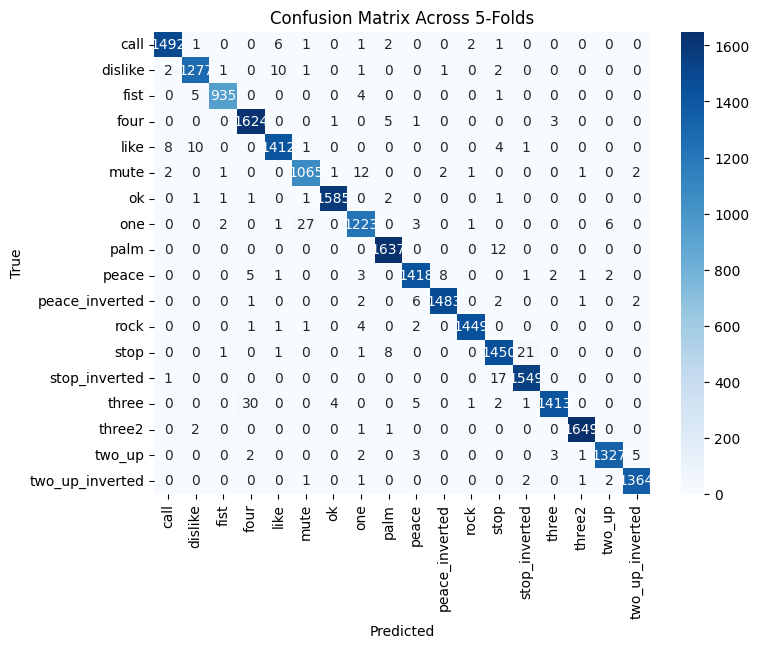

Classification Report Across 5-Folds:

                 precision    recall  f1-score   support

           call       0.99      0.99      0.99      1506
        dislike       0.99      0.99      0.99      1295
           fist       0.99      0.99      0.99       945
           four       0.98      0.99      0.98      1634
           like       0.99      0.98      0.98      1436
           mute       0.97      0.98      0.97      1087
             ok       1.00      1.00      1.00      1592
            one       0.97      0.97      0.97      1263
           palm       0.99      0.99      0.99      1649
          peace       0.99      0.98      0.99      1441
 peace_inverted       0.99      0.99      0.99      1497
           rock       1.00      0.99      1.00      1458
           stop       0.97      0.98      0.98      1482
  stop_inverted       0.98      0.99      0.99      1567
          three       0.99      0.97      0.98      1456
         three2       1.00      1.00      1.00  

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#SVC best parameters
svc_model = SVC(
    tol=0.001,
    shrinking=False,
    max_iter=1000,
    kernel='poly',
    gamma='scale',
    degree=5,
    coef0=0.5,
    C=1
)

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(X, Y):
    # Use iloc[] to index DataFrames by position
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Model training
    svc_model.fit(X_train, y_train)
    
    # Prediction
    y_pred = svc_model.predict(X_test)
    
    # Save output
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=loaded_target_encoder.classes_, yticklabels=loaded_target_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Across 5-Folds')
plt.show()

# Classification report for overall performance
report = classification_report(y_true_all, y_pred_all, target_names=loaded_target_encoder.classes_)
print("Classification Report Across 5-Folds:\n")
print(report)

# Mean accuracy
accuracy = accuracy_score(y_true_all, y_pred_all)
print(f"Mean Accuracy Across 5-Folds: {accuracy * 100:.2f}%")
